# Cats Vs Dogs Classifier

The following code trains a Convolutional Neural Network on the cats-v-dogs dataset available on kaggle to classify cats and dogs.

First we need to download the dataset. The data already has train and validation subdirectories each of which contain subdirectories cats and dogs.

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

--2020-05-10 14:54:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.197.80, 2404:6800:4007:80e::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.197.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  6.80MB/s    in 9.9s    

2020-05-10 14:54:31 (6.64 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

We can check the number of training and testing using the following code:

In [10]:
print('Total training cat images:', len(os.listdir(train_cats_dir)))
print('Total training dog images:', len(os.listdir(train_dogs_dir)))
print('Total testing cat images:', len(os.listdir(validation_cats_dir)))
print('Total testing dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total testing cat images: 500
Total testing dog images: 500


We can see some of the images from the training set. For this we need to import the matplotlib library and set it up for plotting batches of the images.

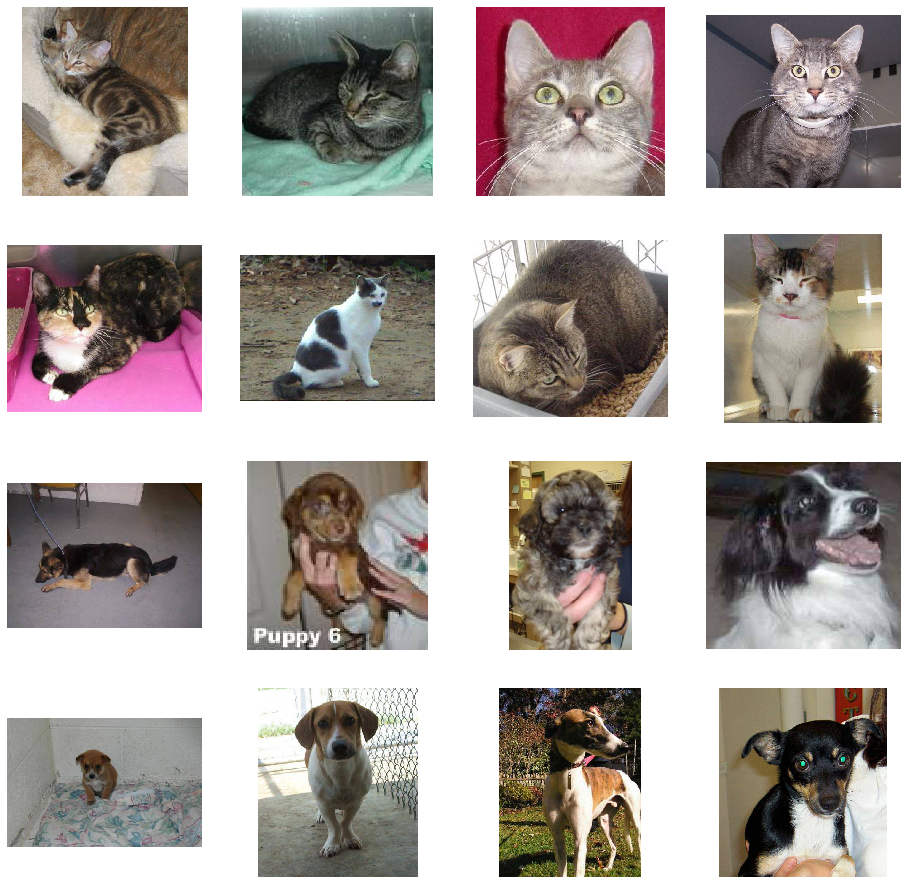

In [12]:
train_cats_names = os.listdir(train_cats_dir)
train_dogs_names = os.listdir(train_dogs_dir)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cats_names[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dogs_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Next we use the ImageDataGenerator class of Keras preprocessing to label the data from the training and directory automatically according to their subclasses. 
For more information on ImageDataGenerator refer: https://keras.io/preprocessing/image/

The code outputs the number of images found in the training and testing sets and the number of classes (2 in this case: cats and dogs)

In [14]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


This next portion of code will define callbacks which help in stopping the training process once certain accuracy has been achieved. For more information on callbacks refer: https://keras.io/callbacks/

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.80):
      print("\nReached 88% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

Next we define the model for training. Here we are using 3 convolution layer followed by a layer of 512 neurons. The model summary provides a convenient overview of the model.

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)      

Next we train the model. Note that the training will stop either if 95% accuracy is reached or the total number of epochs(500 in this case) is completed:

In [30]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1,
      callbacks=[callbacks])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 12s 123ms/step - loss: 0.7064 - acc: 0.5270 - val_loss: 0.6664 - val_acc: 0.6320
Epoch 2/100
100/100 [==============================] - 12s 118ms/step - loss: 0.6742 - acc: 0.5770 - val_loss: 0.6606 - val_acc: 0.5470
Epoch 3/100
100/100 [==============================] - 12s 119ms/step - loss: 0.6509 - acc: 0.6100 - val_loss: 0.6831 - val_acc: 0.5600
Epoch 4/100
100/100 [==============================] - 12s 118ms/step - loss: 0.6356 - acc: 0.6300 - val_loss: 0.6018 - val_acc: 0.6530
Epoch 5/100
100/100 [==============================] - 14s 136ms/step - loss: 0.6224 - acc: 0.6370 - val_loss: 0.5801 - val_acc: 0.6750
Epoch 6/100
100/100 [==============================] - 12s 121ms/step - loss: 0.6114 - acc: 0.6625 - val_loss: 0.5718 - val_acc: 0.6740
Epoch 7/100
100/100 [==============================] - 12s 120ms/step - loss: 0.5944 - acc:

100/100 [==============================] - 12s 121ms/step - loss: 0.4436 - acc: 0.7895 - val_loss: 0.4709 - val_acc: 0.7750
Epoch 60/100
100/100 [==============================] - 12s 124ms/step - loss: 0.4448 - acc: 0.7920 - val_loss: 0.5254 - val_acc: 0.7590
Epoch 61/100
100/100 [==============================] - 14s 141ms/step - loss: 0.4414 - acc: 0.7940 - val_loss: 0.4625 - val_acc: 0.7730
Epoch 62/100
100/100 [==============================] - 14s 139ms/step - loss: 0.4399 - acc: 0.7915 - val_loss: 0.4696 - val_acc: 0.7670
Epoch 63/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4273 - acc: 0.8106
Reached 88% accuracy so cancelling training!
100/100 [==============================] - 14s 139ms/step - loss: 0.4281 - acc: 0.8095 - val_loss: 0.4376 - val_acc: 0.7910


After training, we plot the learning curves to check for overfitting/underfitting and also find possible ways to improve the network:

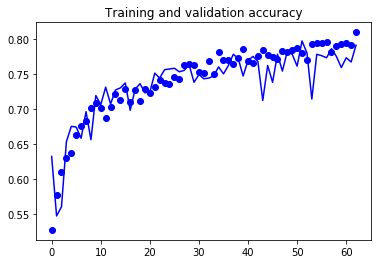

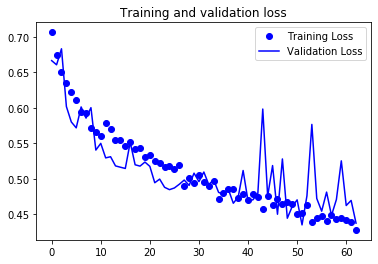

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Finally we can test our model on some images downloaded from the internet. Placing the images in the image_dir, the model predicts whether the images are of a dog or cat.

[1.]
pug-690566_640.jpg is a dog
[1.]
husky-3380548_640.jpg is a dog
[0.]
cat-1192026_640.jpg is a cat
[1.]
dog-3277416_640.jpg is a dog
[1.]
cat-5098930_640.jpg is a dog


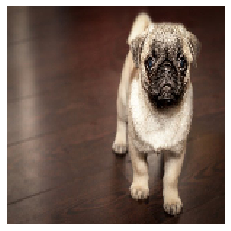

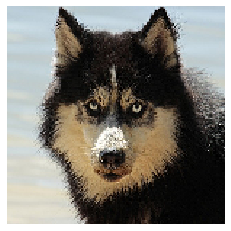

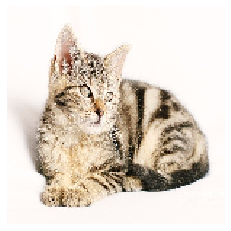

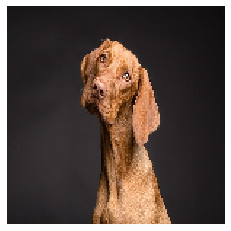

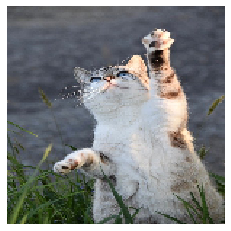

In [60]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_dir='/tmp/downloaded/'

for fn in os.listdir(image_dir):
 
  # predicting images
  path = os.path.join(image_dir, fn)
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  plt.figure()
  plt.axis('Off')
  plt.imshow(img)
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Finally clean up by terminating the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)